# CIFAR-10 Image Classification with CNNs

This notebook implements several Convolutional Neural Network (CNN) architectures to classify images from the CIFAR-10 dataset. We'll build three models—TinyCNN, SimpleCNN, and ImprovedCNN—and train them using PyTorch, evaluating their performance on the test set.


## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random

## Configuration Parameters

In [2]:
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config
batch_size = 64
learning_rate = 1e-3
num_epochs = 10
val_split = 0.1
model_choice = "ImprovedCNN"  # Options: "TinyCNN", "SimpleCNN", "ImprovedCNN"

# Load and Prepare the CIFAR-10 Dataset

### Computing CIFAR-10 Channel Mean and Standard Deviation

Neural networks train more effectively when input images are normalised.
This means adjusting pixel values so that each colour channel (R, G, B) has:

- mean ≈ 0  
- standard deviation ≈ 1  

Different datasets have different pixel distributions, so normalisation
values must be computed separately for each dataset.

Below I compute the mean and standard deviation of the CIFAR-10 training
set by loading all 50,000 images, converting them to tensors, and measuring
their pixel statistics.

In [3]:
from torchvision import datasets, transforms

train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

loader = torch.utils.data.DataLoader(train, batch_size=len(train))
data = next(iter(loader))[0]  # shape: (50000, 3, 32, 32)

mean = data.mean(dim=[0, 2, 3])
std = data.std(dim=[0, 2, 3])

mean, std

Files already downloaded and verified


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

### Data Transforms and Augmentation

Before training the CNN models, the images need to be preprocessed.  
Two steps are important here:

1. **Data Augmentation (training set only)**  
   This artificially increases dataset variability and helps the model generalise.  
   For CIFAR-10, simple augmentations work well:
   - random horizontal flip  
   - small random rotation  

2. **Normalisation (training, validation, and test sets)**  
   Now that the dataset mean and standard deviation have been computed,
   we can normalise each image using those values.  
   This ensures the input tensor values are centred and scaled appropriately,
   which stabilises and speeds up training.

Below I define the transforms for the training set (augmentation + normalisation)
and for the test/validation sets (normalisation only).


In [4]:
cifar10_mean = mean.tolist()
cifar10_std = std.tolist()

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

### Creating the CIFAR-10 Train, Validation and Test Datasets

Now that the preprocessing transforms are defined, the next step is to
attach them to the CIFAR-10 images.

Here I:

1. Download the CIFAR-10 training and test sets (if they are not already on disk).
2. Apply the *training transform* (with augmentation) to the training data.
3. Apply the *test transform* (normalisation only) to the test data.
4. Store the class names for later use when visualising predictions.

After that, I will split the original training set into:
- a **training subset** used to update the model’s weights, and
- a **validation subset** used to monitor performance during training.


In [5]:
data_root = "./data"

# Full training set (will be split into train/validation)
full_train_dataset = torchvision.datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=train_transform,
)

# Test set
test_dataset = torchvision.datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=test_transform,
)

classes = full_train_dataset.classes
print("Classes:", classes)
print("Total training images:", len(full_train_dataset))
print("Test images:", len(test_dataset))


Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Total training images: 50000
Test images: 10000


### Train / Validation Split and DataLoaders

The original CIFAR-10 training set contains 50,000 images. To keep track
of how well the model is learning, I reserve a portion of this data as a
**validation set**.

- The `val_split` parameter controls what fraction is used for validation
  (for example, 0.1 → 10% of the training data).
- The split is done with a fixed random seed so that the same images end
  up in the training and validation sets every time the notebook is run.

After splitting, I wrap each subset in a **DataLoader**:

- The DataLoader shuffles the training data each epoch.
- It batches images together (using `batch_size`) for efficient training.
- Validation and test loaders do not shuffle, so evaluation is deterministic.

In [6]:
# ---- Train / validation split ----
num_train = len(full_train_dataset)
num_val = int(num_train * val_split)
num_actual_train = num_train - num_val

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [num_actual_train, num_val],
    generator=torch.Generator().manual_seed(seed),
)

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# ---- DataLoaders ----
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

Training samples:   45000
Validation samples: 5000


### Quick Visual Check of Training Images

Before defining the CNN models, it is useful to inspect a few samples from
the training set.

This helps to confirm that:

- the dataset has loaded correctly,
- the labels match the images,
- the data augmentation (flips/rotations) looks reasonable,
- and the colours look normal after reversing the normalisation.

Below I:

1. Take one batch from the `train_loader`.
2. Undo the normalisation using the CIFAR-10 mean and standard deviation.
3. Display a small grid of images with their class names.

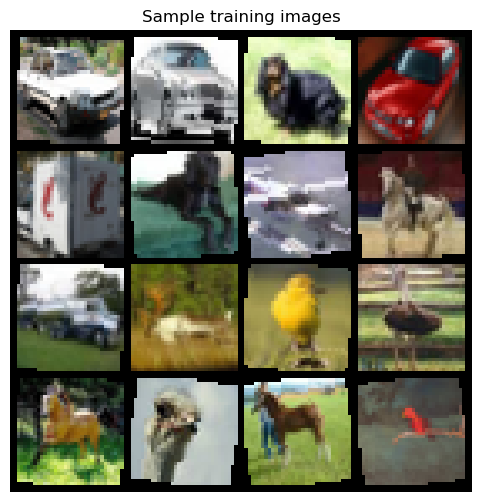

Labels:
automobile, automobile, dog, automobile, truck, dog, airplane, horse, truck, deer, bird, bird, horse, bird, horse, bird


In [7]:
from torchvision.utils import make_grid

# Helper to un-normalise and show a grid of images
def show_batch(images, labels, classes, max_images=16):
    # Select a subset
    images = images[:max_images].cpu()
    labels = labels[:max_images].cpu()

    # Convert mean/std to tensors
    mean_t = torch.tensor(cifar10_mean).view(3, 1, 1)
    std_t = torch.tensor(cifar10_std).view(3, 1, 1)

    # Un-normalise
    images = images * std_t + mean_t
    images = torch.clamp(images, 0.0, 1.0)

    # Make grid
    grid = make_grid(images, nrow=4)
    npimg = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(6, 6))
    plt.imshow(npimg)
    plt.axis("off")
    plt.title("Sample training images")
    plt.show()

    # Print labels underneath in text form
    label_names = [classes[l] for l in labels]
    print("Labels:")
    print(", ".join(label_names))

# Take one batch from the training loader and display it
batch_images, batch_labels = next(iter(train_loader))
show_batch(batch_images, batch_labels, classes)

# Defining the CNN Architectures

In this section I define three convolutional neural network (CNN) models
of increasing complexity:

- **TinyCNN** – a very small network (2 convolutional layers) used mainly
  to check that the training pipeline works end-to-end.
- **SimpleCNN** – a deeper baseline (3 convolutional layers) that should
  achieve reasonable accuracy on CIFAR-10.
- **ImprovedCNN** – the most expressive model, using additional
  convolutional layers and batch normalisation to improve stability and
  performance.

All three models:
- take a 3×32×32 RGB image as input (CIFAR-10 format),
- use ReLU activations,
- apply max pooling to reduce spatial resolution,
- end with one or two fully connected layers that output logits for the
  10 CIFAR-10 classes.

Later, I will choose which architecture to train using the `model_choice`
configuration variable defined at the top of the notebook.


In [8]:
class TinyCNN(nn.Module):
    """
    A very small CNN: 2 conv layers + 2 linear layers.
    Good for quick tests and checking the pipeline.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 32 -> 16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 16 -> 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class SimpleCNN(nn.Module):
    """
    Baseline CNN: 3 conv layers + 2 linear layers.
    Deeper than TinyCNN, suitable for decent CIFAR-10 accuracy.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 32 -> 16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 16 -> 8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 8 -> 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class ImprovedCNN(nn.Module):
    """
    Deeper CNN with batch normalisation.
    Designed to achieve higher accuracy on CIFAR-10.
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # Block 1: 3 -> 64
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 32 -> 16
        )

        # Block 2: 64 -> 128
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 16 -> 8
        )

        # Block 3: 128 -> 256
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 8 -> 4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x


def count_parameters(model):
    """Utility to count trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_model(name: str, num_classes: int = 10):
    """Factory function to build a model by name."""
    name = name.lower()
    if name == "tinycnn" or name == "tiny":
        model = TinyCNN(num_classes)
    elif name == "simplecnn" or name == "simple":
        model = SimpleCNN(num_classes)
    elif name == "improvedcnn" or name == "improved":
        model = ImprovedCNN(num_classes)
    else:
        raise ValueError(f"Unknown model name: {name}")

    print(f"Using model: {model.__class__.__name__}")
    print(f"Trainable parameters: {count_parameters(model):,}")
    return model.to(device)


In [9]:
model = get_model(model_choice)
dummy = torch.randn(1, 3, 32, 32).to(device)
out = model(dummy)
print("Output shape:", out.shape)

Using model: ImprovedCNN
Trainable parameters: 3,249,994
Output shape: torch.Size([1, 10])


# Training and Evaluation Functions

To train any of the CNNs, I need a reusable training loop.  
The idea is:

1. **Loss function**  
   For multi-class classification, I use `CrossEntropyLoss`, which compares
   the model's logits with the ground truth class indices.

2. **Optimiser**  
   I use Adam with a fixed learning rate. It updates the model parameters
   based on the gradients computed from the loss.

3. **Epoch loop**  
   For each epoch:
   - switch the model to training mode,
   - iterate over all mini-batches from the training DataLoader,
   - compute loss and accuracy,
   - update the weights via backpropagation.

4. **Validation**  
   After each epoch, I evaluate the model on the validation set (no gradient
   computation). This gives validation loss and accuracy, which help detect
   overfitting and select the best-performing model.

The helper functions below implement:

- `train_one_epoch` – runs one full pass over the training set.
- `evaluate` – computes loss and accuracy on validation or test data.
- `train_model` – orchestrates the full training process over many epochs,
  records metrics, and keeps track of the best validation accuracy.


In [10]:
# Loss function (same for all models)
criterion = nn.CrossEntropyLoss()


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    best_val_acc = 0.0
    best_state_dict = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch:03d}/{num_epochs:03d} | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc*100:5.2f}% | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc*100:5.2f}%"
        )

    print(f"\nBest validation accuracy: {best_val_acc*100:.2f}%")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, history


# Training the Selected CNN Model

Now that the training and evaluation functions are defined, I can train
one of the three CNN architectures. The choice of model is controlled by
the `model_choice` variable defined at the top of the notebook.

Here I:

1. Create the model using `get_model(model_choice)`.
2. Train it using the `train_model` function.
3. Store the training and validation metrics in a history dictionary so
   that I can plot the learning curves later.

The model will automatically keep the weights that achieved the best
validation accuracy during training.

In [11]:
# Instantiate the selected model
model = get_model(model_choice)

# Train the model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

Using model: ImprovedCNN
Trainable parameters: 3,249,994
Epoch 001/010 | Train loss: 1.5345, acc: 43.70% | Val loss: 1.1683, acc: 57.38%
Epoch 002/010 | Train loss: 1.1358, acc: 59.87% | Val loss: 1.0620, acc: 62.56%
Epoch 003/010 | Train loss: 0.9627, acc: 66.60% | Val loss: 1.0939, acc: 65.44%
Epoch 004/010 | Train loss: 0.8477, acc: 71.19% | Val loss: 0.7237, acc: 74.10%
Epoch 005/010 | Train loss: 0.7624, acc: 74.24% | Val loss: 0.6497, acc: 77.22%
Epoch 006/010 | Train loss: 0.7001, acc: 76.32% | Val loss: 0.6508, acc: 77.42%
Epoch 007/010 | Train loss: 0.6427, acc: 78.57% | Val loss: 0.6527, acc: 77.68%
Epoch 008/010 | Train loss: 0.5895, acc: 80.30% | Val loss: 0.5771, acc: 80.26%
Epoch 009/010 | Train loss: 0.5547, acc: 81.51% | Val loss: 0.5623, acc: 81.00%
Epoch 010/010 | Train loss: 0.5146, acc: 82.89% | Val loss: 0.5031, acc: 83.30%

Best validation accuracy: 83.30%


# Visualising Training and Validation Curves

To understand how well the model has learned over time, it is useful to
plot the training and validation metrics across epochs.

From the `history` dictionary returned by `train_model`, I have:

- `train_loss` – average loss on the training set per epoch
- `val_loss` – average loss on the validation set per epoch
- `train_acc` – training accuracy per epoch
- `val_acc` – validation accuracy per epoch

By plotting these:

- I can check whether the model is overfitting (training loss down but
  validation loss up).
- I can see whether training has roughly converged or would benefit from
  more epochs or different hyperparameters.


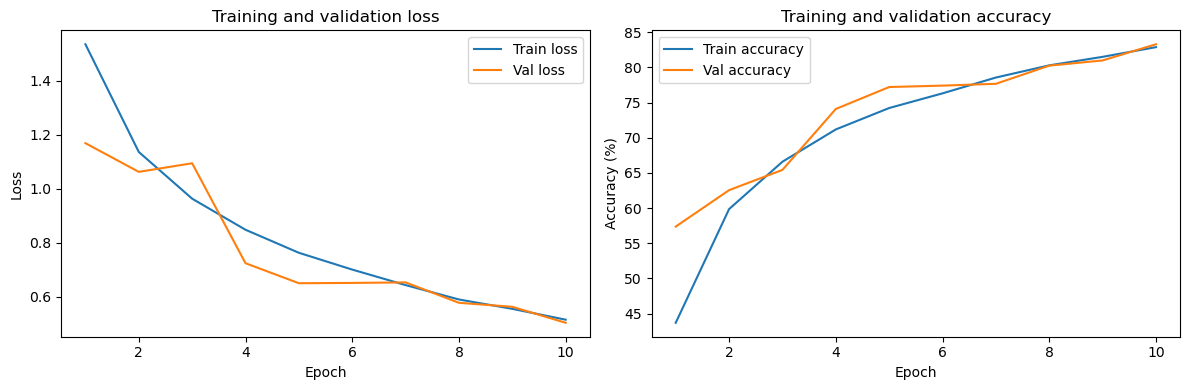

In [12]:
epochs = range(1, num_epochs + 1)

# Convert accuracies to percentages for nicer plotting
train_acc = [a * 100 for a in history["train_acc"]]
val_acc = [a * 100 for a in history["val_acc"]]

plt.figure(figsize=(12, 4))

# ---- Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()

# ---- Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train accuracy")
plt.plot(epochs, val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Final Evaluation on the Test Set

The training and validation curves show how the model behaved during
training, but the real measure of performance is how well it generalises
to **unseen data**.

For this, I use the held-out CIFAR-10 **test set** (10,000 images that
were never used for training or validation).

I reuse the `evaluate` function to compute:

- the average loss on the test set, and
- the overall test accuracy.

This gives a single summary number for how well the trained model
performs on new images.

In [13]:
test_loss, test_acc = evaluate(model, test_loader, device)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc*100:.2f}%")

Test loss: 0.4675
Test accuracy: 84.13%


## Extra: Confusion Matrix

Overall test accuracy is a useful summary, but it does not show *which*
classes the model finds difficult.

A **confusion matrix** compares:

- the true class (rows) and
- the predicted class (columns)

for every test image.

From this matrix I can see, for example:

- if the model often mistakes *cats* for *dogs*,
- or *cars* for *trucks*, etc.

The raw confusion matrix shows how many images fall into each
true/predicted category, but it does not show the *relative* importance.

By normalising each row so that it sums to 100%, I get a clearer picture
of how the model behaves for each class:

- The diagonal shows the **percentage of correct predictions**.
- Off-diagonal cells show **how often each class is confused with others**.
- Rows now become directly comparable, even if datasets are imbalanced.

This representation is much easier to interpret.

Below I:

1. Collect all predictions for the test set.
2. Build a confusion matrix.
3. Plot it as a heatmap with class names on both axes.

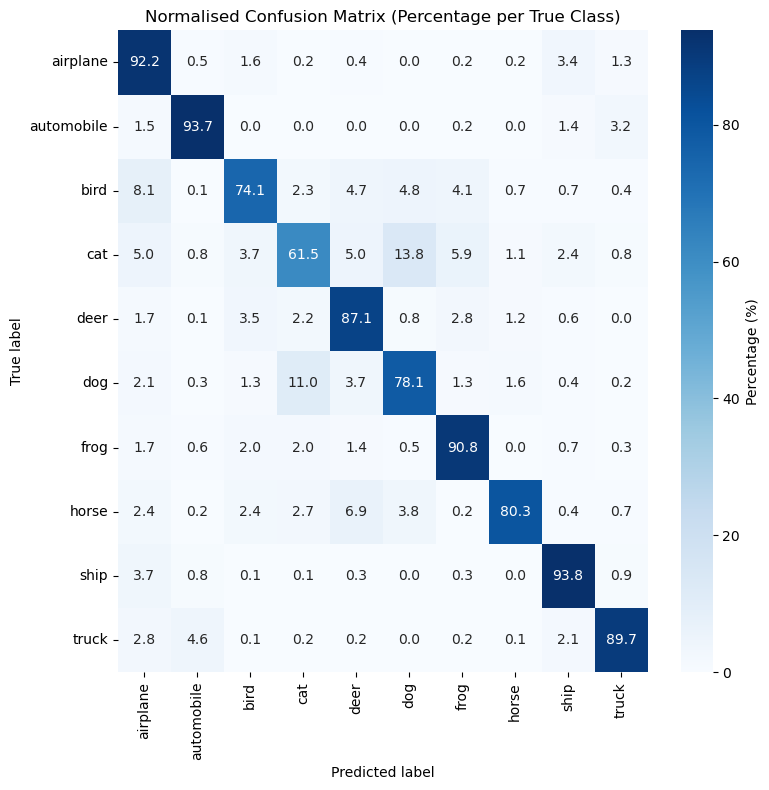

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Collect all predictions and true labels
all_targets = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Build confusion matrix (counts)
cm = confusion_matrix(all_targets, all_preds)

# Normalise each row (true class) to sum to 1
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 8))
sns.heatmap(
    cm_norm * 100,          # convert to percentages
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
    cbar_kws={'label': 'Percentage (%)'}
)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Normalised Confusion Matrix (Percentage per True Class)")
plt.tight_layout()
plt.show()

## Extra: Sample Test Images with Predictions

To get an intuitive feel for what the model is doing, it is helpful to
look at individual predictions.

Below I:

1. Take one batch from the test DataLoader.
2. Run the trained model to obtain predictions.
3. Display a small grid of images.
4. Show both the **true label** and the **predicted label** for each image.

Correct predictions are shown in one colour and incorrect predictions in
another, so it is easy to spot mistakes visually.

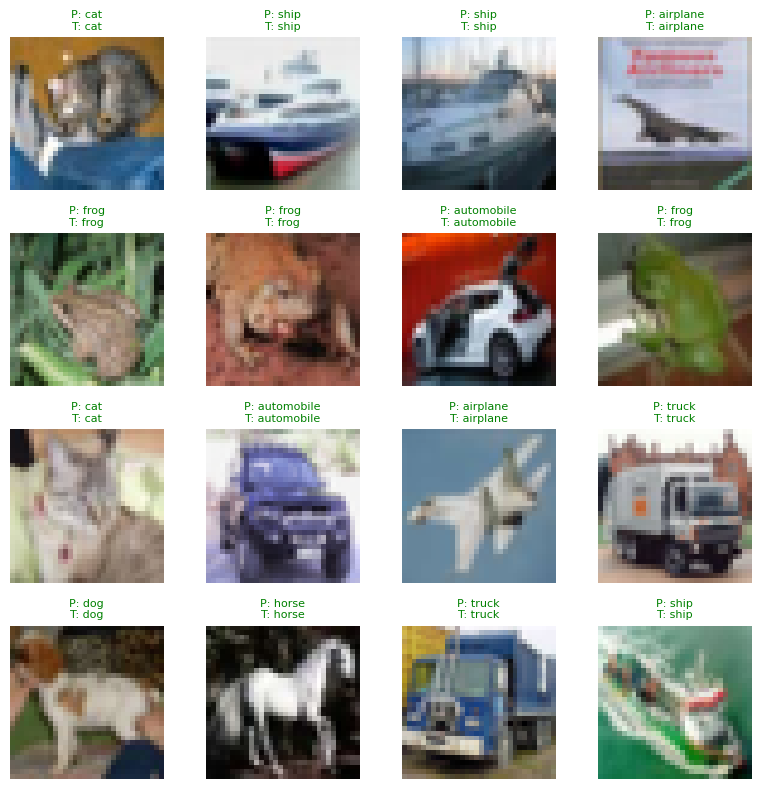

In [15]:
def show_predictions(model, dataloader, classes, max_images=16):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, preds = outputs.max(1)

            # Move to CPU for plotting
            inputs = inputs.cpu()
            targets = targets.cpu()
            preds = preds.cpu()

            # Convert mean/std to tensors
            mean_t = torch.tensor(cifar10_mean).view(3, 1, 1)
            std_t = torch.tensor(cifar10_std).view(3, 1, 1)

            num_in_batch = inputs.size(0)
            num_to_show = min(max_images - images_shown, num_in_batch)

            plt.figure(figsize=(8, 8))
            for i in range(num_to_show):
                img = inputs[i] * std_t + mean_t   # un-normalise
                img = torch.clamp(img, 0.0, 1.0)

                true_label = classes[targets[i]]
                pred_label = classes[preds[i]]
                correct = (targets[i] == preds[i]).item()

                plt.subplot(4, 4, i + 1)
                plt.imshow(img.permute(1, 2, 0).numpy())
                plt.axis("off")

                title_colour = "green" if correct else "red"
                plt.title(
                    f"P: {pred_label}\nT: {true_label}",
                    fontsize=8,
                    color=title_colour
                )

            plt.tight_layout()
            plt.show()

            images_shown += num_to_show
            if images_shown >= max_images:
                break

# Show 16 predictions from the test set
show_predictions(model, test_loader, classes, max_images=16)
